# Simple Neural Network created form scratch
#### Created for use on MNist data set attained from kaggle.com

### 1) Importing libraries & preparing data

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [85]:
# Read in dataset attained from kaggle.com
df = pd.read_csv("train.csv")

In [86]:
# Split data into a training and test dataset.
split = int(len(df)*0.8)
df_train = df[:split].values
df_test = df[split:].values
print(f'Shape of training data: {df_train.shape} and shape of test data: {df_test.shape}')

Shape of training data: (33600, 785) and shape of test data: (8400, 785)


In [87]:
# Set the features to x and the labels to y.
xtrain, xtest = df_train[:,1:], df_test[:,1:]
ytrain, ytest = df_train[:,0], df_test[:,0]

In [88]:
# Returns the labels as 10 columns with the a one in the column number which matches the labels values.
def get_dummies(arr):
    output = np.zeros([(len(arr)),10])
    mask = pd.get_dummies(arr)
    output[mask]=1
    return output

#Scales values in features between 0 and 1.
def scale(arr):
    return arr/np.max(arr)

In [89]:
xtrain, xtest = scale(xtrain), scale(xtest)
ytrain, ytest = get_dummies(ytrain), get_dummies(ytest)
print(f'Shape of xtrain: {xtrain.shape} and shape of ytrain: {ytrain.shape}')


Shape of xtrain: (33600, 784) and shape of ytrain: (33600, 10)


### 2) Creating the Neural Network

In [91]:
class NeuralNet:
    def __init__(self):
        self.activations_map = {"relu":self.relu,
                            "softmax":self.softmax
                            }

    # Relu function return 0 if value less than 1. else returns value
    def relu(self, a):
        return np.maximum(0,a)
    
    # Derivative of relu function.
    def der_relu(self, z):
        return z>0

    # Softmax function. Determines what fraction of total output a value makes up. Range between 0 and 1. 
    def softmax(self, test):
        return np.exp(test)/np.sum(np.exp(test),axis=1).reshape(-1,1)

    # Creates the weights and biases based on the number of layers and nodes for each layer.
    def initialize_layers(self, layers:np.array):
        weights, bias = [], []
        input = layers[0]

        for val in layers[1:]:
            weights.append((np.random.rand(input, val)-0.5))
            bias.append(np.random.rand(1, val))
            input = val
        self.weights, self.bias = weights, bias
    
    # Performs the neural networks forward propagation returns the pre and post activation values for each layer.
    def forward_prop(self, input_data, activations):
        if len(self.weights)!=len(activations):
            raise ValueError(f"Need an activation function for each layer. You have given {len(activations)} need {len(self.weights)}")
        
        self.input_data = input_data
        alist, zlist = [],[input_data]
        for i in range(len(self.weights)):
            a = input_data.dot(self.weights[i])+self.bias[i]
            z = self.activations_map[activations[i]](a)
            alist.append(a)
            zlist.append(z)
            input_data = z
        self.z, self.a, = zlist, alist

    # Perform back propagation.
    def back_prop(self, true_values):
        self.weight_derivatives, self.bias_derivatives = [], []
        m = len(self.input_data)
        

        for i in range(len(self.z)-1):
            count = 0
            dz= (self.z[-1]-true_values)
            while i - count !=0:
                dz = dz.dot(self.weights[-count-1].T)*self.der_relu(self.z[(-count-2)])
                count+=1

            self.weight_derivatives.append(((1/m)*dz.T.dot(self.z[-i-2])).T)
            self.bias_derivatives.append((1/m)*np.sum(dz,axis=0))

    # Uses derivatives found in backpropagation in combination with learning rate to update the weights and biases
    def update_params(self):
        for i in range(len(self.weight_derivatives)):
            self.weights[i] = self.weights[i]-(self.lr*self.weight_derivatives[-i-1])
            self.bias[i] = self.bias[i]-(self.lr*self.bias_derivatives[-i-1])

    # For training model. Runs forward and Back propagtion repeatedly for the set number of epochs, while updating parameters each time. 
    def gradient(self, input_data, layers:np.array, activations:list, true_values,lr, epochs):
        self.lr = lr
        self.history = []
        self.initialize_layers(layers)
        self.forward_prop(input_data, activations)
        
        for i in range(epochs):
            self.back_prop(true_values)
            self.update_params()
            self.forward_prop(input_data, activations)
            self.history.append(self.z[-1])
        print("Training complete")

In [83]:
# Functions used to determine accuracy of models predictions.
def get_predictions(A2):
    return np.argmax(A2,axis=1)

def pred_acc(predictions, test):
     model_pred = get_predictions(predictions)
     test_pred = get_predictions(test)
     return np.sum(model_pred==test_pred)/len(test_pred)

### 3) Training the network on test data

######  - Network has an input layer of 784 nodes, a hidden layer of 100 nodes, and an output layer of 10 nodes. 

In [92]:
N1 = NeuralNet()
N1.gradient(xtrain,np.array([784,100,10]),["relu", "softmax"], ytrain, lr = 0.1,epochs=500)

Training complete


### 4) Checking Model performance

* First on training data
* Second on test data

In [93]:
acc_train = pred_acc(N1.history[-1], ytrain)
print(f"Accuracy on training data was {round(acc_train*100,2)}%")

Accuracy on training data was 90.83%


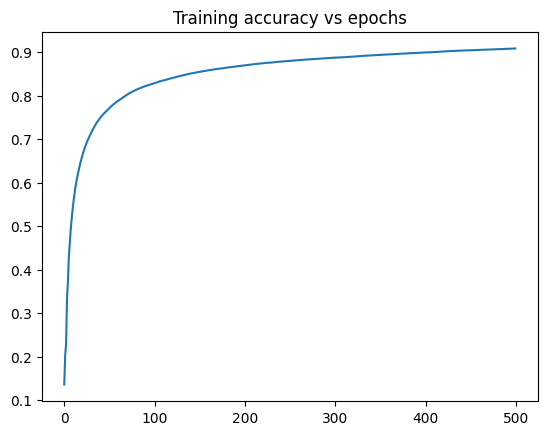

In [94]:
acc = []
for val in N1.history:
    acc.append(pred_acc(val,ytrain))
plt.title("Training accuracy vs epochs")
plt.plot(acc)
plt.show()

In [95]:
N1.forward_prop(xtest,["relu", "softmax"])
acc_test = pred_acc(N1.z[-1], ytest)
print(f"Accuracy on test data was {round(acc_test*100,2)}%")

Accuracy on test data was 90.26%
